In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Télécharger les données
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [ ]:
#prétraiter les données
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
# Diviser en ensembles étiquetés et non étiquetés
x_train_labeled, x_train_unlabeled, y_train_labeled, _ = train_test_split(x_train, y_train, test_size=0.8, stratify=y_train)

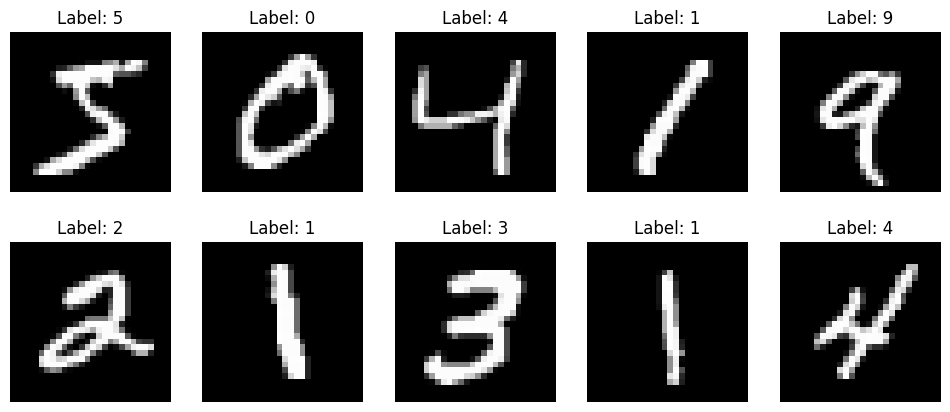

In [ ]:
# Visualiser quelques exemples du jeu de données original
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
for ax, img, label in zip(axes.ravel(), x_train[:10], y_train[:10]):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

In [ ]:
# Définir l'auto-encodeur convolutionnel
input_img = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# Entraîner l'auto-encodeur sur les données non étiquetées
autoencoder.fit(x_train_unlabeled, x_train_unlabeled, epochs=50, batch_size=128, shuffle=True)

Epoch 1/50
375/375 [==============================] - 53s 131ms/step - loss: 0.2251
Epoch 2/50
375/375 [==============================] - 58s 155ms/step - loss: 0.1401
Epoch 3/50
375/375 [==============================] - 50s 133ms/step - loss: 0.1272
Epoch 4/50
375/375 [==============================] - 53s 140ms/step - loss: 0.1206
Epoch 5/50
375/375 [==============================] - 50s 133ms/step - loss: 0.1164
Epoch 6/50
375/375 [==============================] - 50s 134ms/step - loss: 0.1132
Epoch 7/50
375/375 [==============================] - 49s 130ms/step - loss: 0.1106
Epoch 8/50
375/375 [==============================] - 50s 134ms/step - loss: 0.1086
Epoch 9/50
375/375 [==============================] - 51s 136ms/step - loss: 0.1070
Epoch 10/50
375/375 [==============================] - 50s 134ms/step - loss: 0.1056
Epoch 11/50
375/375 [==============================] - 51s 135ms/step - loss: 0.1044
Epoch 12/50
375/375 [==============================] - 50s 134ms/step - lo

375/375 [==============================] - 5s 14ms/step


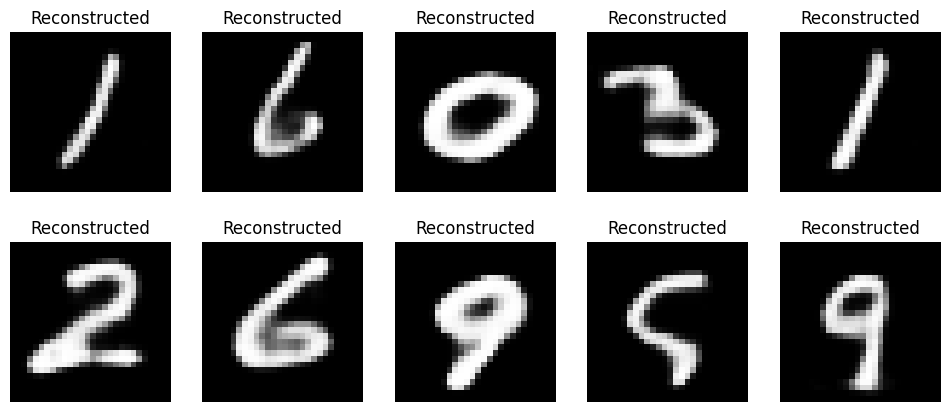

In [ ]:
# Visualiser les images reconstruites par l'auto-encodeur
decoded_imgs = autoencoder.predict(x_train_labeled)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
for ax, orig, recon in zip(axes.ravel(), x_train_labeled[:10], decoded_imgs[:10]):
    ax.imshow(orig.squeeze(), cmap='gray')
    ax.set_title('Original')
    ax.axis('off')
    ax.imshow(recon.squeeze(), cmap='gray')
    ax.set_title('Reconstructed')
    ax.axis('off')
plt.show()

In [ ]:
# Extraire les caractéristiques avec l'encodeur
encoder = keras.Model(input_img, encoded)
x_train_features = encoder.predict(x_train_labeled)

375/375 [==============================] - 3s 7ms/step


In [ ]:
# Définir et entraîner le modèle de classification
input_features = keras.Input(shape=x_train_features.shape[1:])
x = keras.layers.Flatten()(input_features)
x = keras.layers.Dense(128, activation='relu')(x)
output = keras.layers.Dense(10, activation='softmax')(x)
classifier = keras.Model(input_features, output)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.fit(x_train_features, y_train_labeled, epochs=10, batch_size=128, validation_data=(encoder.predict(x_test), y_test))

313/313 [==============================] - 2s 7ms/step
Epoch 1/10
94/94 [==============================] - 1s 6ms/step - loss: 1.7867 - accuracy: 0.4402 - val_loss: 1.1415 - val_accuracy: 0.6407
Epoch 2/10
94/94 [==============================] - 1s 6ms/step - loss: 0.9312 - accuracy: 0.7173 - val_loss: 0.7697 - val_accuracy: 0.7755
Epoch 3/10
94/94 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.7897 - val_loss: 0.6138 - val_accuracy: 0.8151
Epoch 4/10
94/94 [==============================] - 0s 5ms/step - loss: 0.5769 - accuracy: 0.8268 - val_loss: 0.5105 - val_accuracy: 0.8603
Epoch 5/10
94/94 [==============================] - 0s 4ms/step - loss: 0.4952 - accuracy: 0.8557 - val_loss: 0.4524 - val_accuracy: 0.8745
Epoch 6/10
94/94 [==============================] - 0s 5ms/step - loss: 0.4368 - accuracy: 0.8743 - val_loss: 0.4193 - val_accuracy: 0.8761
Epoch 7/10
94/94 [==============================] - 0s 5ms/step - loss: 0.3973 - accuracy: 0.8848 - val_l

In [ ]:
# Comparer les performances avec et sans l'auto-encodeur
# Définir et entraîner un modèle de classification sans les caractéristiques d'auto-encodeur
input_img = keras.Input(shape=(28, 28, 1))
x = keras.layers.Flatten()(input_img)
x = keras.layers.Dense(128, activation='relu')(x)
output = keras.layers.Dense(10, activation='softmax')(x)
classifier_baseline = keras.Model(input_img, output)
classifier_baseline.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier_baseline.fit(x_train_labeled, y_train_labeled, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/10
94/94 [==============================] - 2s 11ms/step - loss: 0.7080 - accuracy: 0.8163 - val_loss: 0.3649 - val_accuracy: 0.8938
Epoch 2/10
94/94 [==============================] - 1s 11ms/step - loss: 0.3080 - accuracy: 0.9128 - val_loss: 0.2821 - val_accuracy: 0.9207
Epoch 3/10
94/94 [==============================] - 1s 11ms/step - loss: 0.2445 - accuracy: 0.9299 - val_loss: 0.2503 - val_accuracy: 0.9264
Epoch 4/10
94/94 [==============================] - 1s 7ms/step - loss: 0.2068 - accuracy: 0.9398 - val_loss: 0.2244 - val_accuracy: 0.9361
Epoch 5/10
94/94 [==============================] - 1s 7ms/step - loss: 0.1757 - accuracy: 0.9507 - val_loss: 0.2071 - val_accuracy: 0.9401
Epoch 6/10
94/94 [==============================] - 1s 9ms/step - loss: 0.1503 - accuracy: 0.9566 - val_loss: 0.1907 - val_accuracy: 0.9454
Epoch 7/10
94/94 [==============================] - 1s 8ms/step - loss: 0.1299 - accuracy: 0.9638 - val_loss: 0.1842 - val_accuracy: 0.9461
Epoch 8/10
94/94 

In [ ]:
# Évaluer les performances du modèle de base
_, baseline_accuracy = classifier_baseline.evaluate(x_test, y_test)
print(f"Test accuracy without autoencoder features: {baseline_accuracy:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1711 - accuracy: 0.9497
Test accuracy without autoencoder features: 0.950


In [ ]:
# Évaluer les performances du modèle avec les caractéristiques d'auto-encodeur
_, ae_accuracy = classifier.evaluate(encoder.predict(x_test), y_test)
print(f"Test accuracy with autoencoder features: {ae_accuracy:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.3107 - accuracy: 0.9108
Test accuracy with autoencoder features: 0.911
